## PART 1

### Deepwalk.py

In [3]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import numpy as np
import networkx as nx
from random import randint
from gensim.models import Word2Vec


############## Task 1
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):
    
    ##################
    visited_vertices = [node]
    for i in range(walk_length):
      neighbors = list( G.neighbors(visited_vertices[i]) )
      visited_vertices.append( neighbors[randint(0, len(neighbors)-1)] )
    ##################
    
    walk = [str(node) for node in visited_vertices]
    return walk


############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):
    walks = []
    
    ##################
    for i in range(num_walks):
      nodes = list(G.nodes())
      for j in range(len(nodes)):
        walk = random_walk(G, nodes[j], walk_length)
        walks.append(walk)
    ##################
    
    return walks

# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    # error with vector_size but seem to work on colab with size argument
    model = Word2Vec(size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model

### Visualization.py

Number of nodes: 33226
Number of edges: 354529
Generating walks
Training word2vec


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


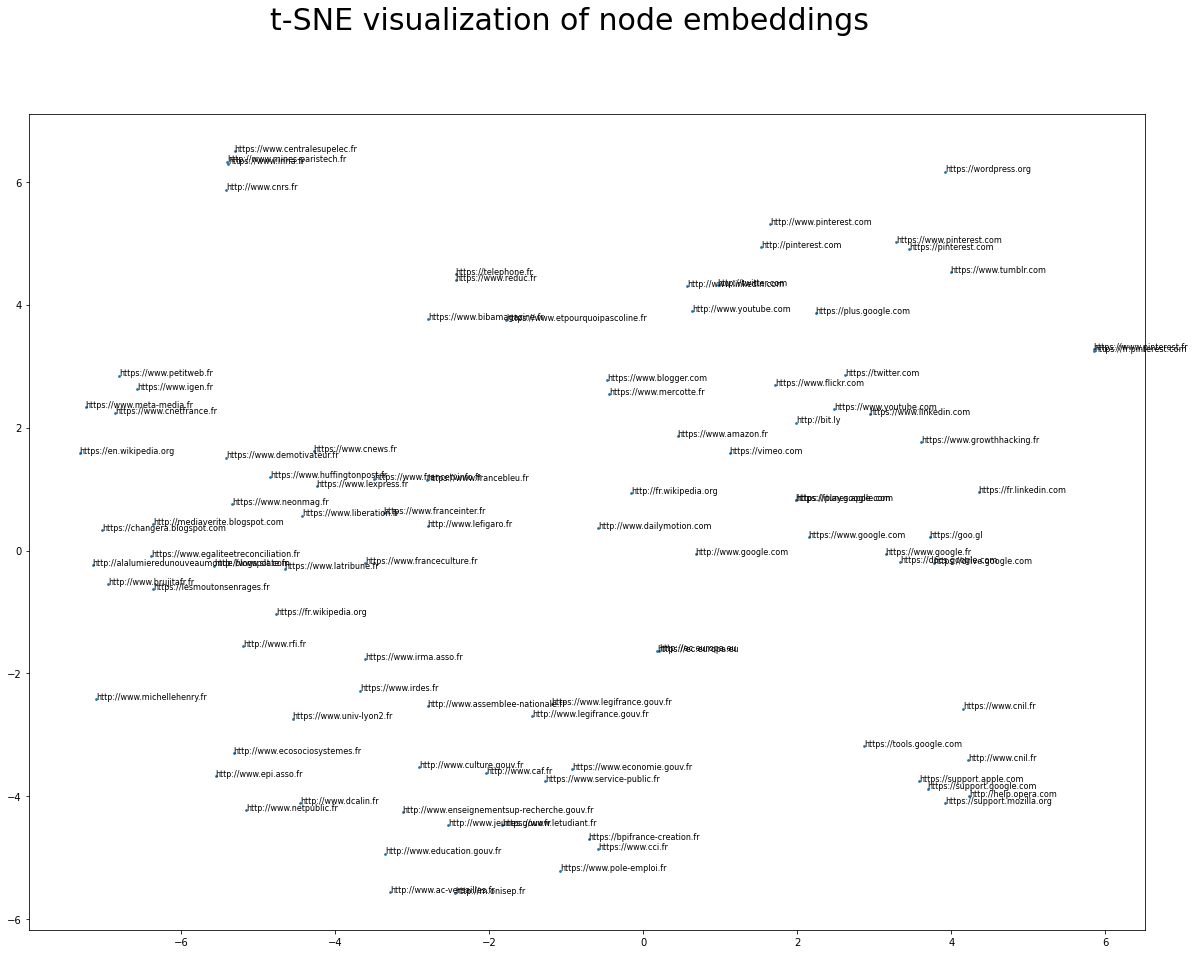

In [4]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import networkx as nx
import numpy as np
#from deepwalk import deepwalk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Loads the web graph
G = nx.read_weighted_edgelist('./web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20

##################
model = deepwalk(G, n_walks, walk_length, n_dim)
##################


############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):
    
    # your code here
    # error with index_to_key but seem to work on colab with index2entity argument
    most_frequent_nodes = model.wv.index2entity[:n]
    vecs = np.empty(shape=(n, dim))
    
    ##################
    for idx, node in enumerate(most_frequent_nodes):
      vecs[idx,:] = model.wv[node]
    ##################

    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2)

    vecs_pca = my_pca.fit_transform(vecs)
    vecs_tsne = my_tsne.fit_transform(vecs_pca)

    fig, ax = plt.subplots()
    ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
    for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], most_frequent_nodes):     
        ax.annotate(node, xy=(x, y), size=8)
    fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
    fig.set_size_inches(20,15)
    plt.show()


visualize(model, 100, n_dim)

### NodeClassification.py

Number of nodes: 34
Number of edges: 78


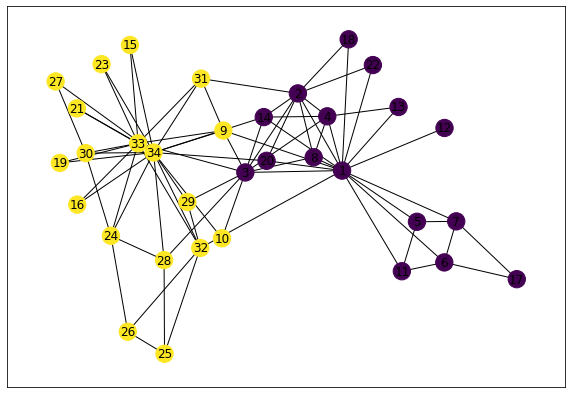

Generating walks
Training word2vec
DeepWalk accuracy: 1.0
SpectralEmbedding accuracy: 0.42857142857142855


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [5]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import networkx as nx
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score
#from deepwalk import deepwalk
from matplotlib import pyplot as plt

# Loads the karate network
G = nx.read_weighted_edgelist('./karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)



############## Task 5

##################
plt.figure(figsize=(10,7))
nx.draw_networkx(G, node_color = y)
plt.show()
##################


############## Task 6
n_dim = 128
n_walks = 10
walk_length = 20

# your code here
model = deepwalk(G, n_walks, walk_length, n_dim)

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G.nodes()):
    embeddings[i,:] = model.wv[str(node)]

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]



############## Task 7

##################
Logit = LogisticRegression()
Logit.fit(X_train, y_train)
y_pred = Logit.predict(X_test)
print(f"DeepWalk accuracy: {accuracy_score(y_test, y_pred)}")
##################




############## Task 8

##################
A = nx.to_numpy_matrix(G)

Spectral_Embedding = SpectralEmbedding(affinity = "precomputed")
X_SpectralEmbedding = Spectral_Embedding.fit_transform(A)

X_train_SpectralEmbedding = X_SpectralEmbedding[idx_train,:]
X_test_SpectralEmbedding = X_SpectralEmbedding[idx_test,:]

Logit_SpectralEmbedding = LogisticRegression()
Logit_SpectralEmbedding.fit(X_train_SpectralEmbedding, y_train)

y_pred_SpectralEmbedding = Logit_SpectralEmbedding.predict(X_test_SpectralEmbedding)

print(f"SpectralEmbedding accuracy: {accuracy_score(y_test, y_pred_SpectralEmbedding)}")
##################

## PART 2

### utils.py

In [6]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import scipy.sparse as sp
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

def normalize_adjacency(A):
    ############## Task 9
    
    ##################
    A += sp.identity( A.shape[0] )

    diagonal_elements = A.dot( np.ones(A.shape[0]) )
    diagonal_elements = np.power(diagonal_elements, -0.5)
    D = sp.diags(diagonal_elements)

    A_normalized = ( D.dot(A) ).dot(D)
    ##################

    return A_normalized


def load_cora():
    idx_features_labels = np.genfromtxt("./cora.content", dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    
    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("./cora.cites", dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

### models.py

In [7]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13
        
        ##################
        x = self.fc1(x_in)

        Z0 = self.relu(torch.mm(adj, x))
        Z0 = self.dropout(Z0)

        Z1 = self.fc2(Z0)
        Z1 = self.relu(torch.mm(adj, Z1))

        x = self.fc3(Z1)
        ##################

        return F.log_softmax(x, dim=1), Z1

### gnn_karate.py

In [8]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

#from utils import normalize_adjacency, sparse_to_torch_sparse
#from models import GNN


# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('./karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(f"G.number_of_nodes: {G.number_of_nodes()}")
print(f"G.number_of_edges: {G.number_of_edges()}")

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.ones((n,n)) # Generates node features


# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)[0]
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)[0]
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()

G.number_of_nodes: 34
G.number_of_edges: 78
Epoch: 001 loss_train: 0.6963 acc_train: 0.5556 time: 0.3890s
Epoch: 002 loss_train: 0.6963 acc_train: 0.5556 time: 0.0049s
Epoch: 003 loss_train: 0.6953 acc_train: 0.5556 time: 0.0045s
Epoch: 004 loss_train: 0.6934 acc_train: 0.5556 time: 0.0048s
Epoch: 005 loss_train: 0.6978 acc_train: 0.5556 time: 0.0046s
Epoch: 006 loss_train: 0.6856 acc_train: 0.5556 time: 0.0047s
Epoch: 007 loss_train: 0.6880 acc_train: 0.5926 time: 0.0046s
Epoch: 008 loss_train: 0.6917 acc_train: 0.5556 time: 0.0047s
Epoch: 009 loss_train: 0.6873 acc_train: 0.5185 time: 0.0047s
Epoch: 010 loss_train: 0.6751 acc_train: 0.5556 time: 0.0046s
Epoch: 011 loss_train: 0.6935 acc_train: 0.5556 time: 0.0045s
Epoch: 012 loss_train: 0.6944 acc_train: 0.5556 time: 0.0046s
Epoch: 013 loss_train: 0.6855 acc_train: 0.5556 time: 0.0046s
Epoch: 014 loss_train: 0.6769 acc_train: 0.5556 time: 0.0046s
Epoch: 015 loss_train: 0.6866 acc_train: 0.5556 time: 0.0041s
Epoch: 016 loss_train: 0.6

### Question 4

In [8]:
import numpy as np
from math import *

hat_A = np.array([[1./3, 1./sqrt(6), 1./3, 0],
                  [1./sqrt(6), 1./2, 0, 0],
                  [1./3, 0, 1./3, 1./sqrt(6)],
                  [0, 0, 1./sqrt(6), 1./2]])

X = np.ones((4,1))

W_0 = np.array([[0.5, -0.2]])

W_1 = np.array([[0.3, -0.4, 0.8, 0.5],
                [-1.1, 0.6, -0.1, 0.7]])

print(f"Shapes: hat_A: {hat_A.shape}, X: {X.shape}, W_0: {W_0.shape}, W_1: {W_1.shape}")

Z_0 = np.maximum(hat_A @ X @ W_0, 0, hat_A @ X @ W_0)

Z_1 = np.maximum(hat_A @ Z_0 @ W_1, 0, hat_A @ Z_0 @ W_1)

print(f"\nZ_1:\n{Z_1}")

Shapes: hat_A: (4, 4), X: (4, 1), W_0: (1, 2), W_1: (2, 4)

Z_1:
[[0.16311012 0.         0.43496031 0.2718502 ]
 [0.13394345 0.         0.35718254 0.22323908]
 [0.16311012 0.         0.43496031 0.2718502 ]
 [0.13394345 0.         0.35718254 0.22323908]]


### gnn_cora.py

Dataset has 2708 nodes, 5429 edges, 1433 features.
Epoch: 001 loss_train: 1.9581 acc_train: 0.1108 loss_val: 1.9446 acc_val: 0.1292 time: 0.0175s
Epoch: 002 loss_train: 1.9431 acc_train: 0.1342 loss_val: 1.9314 acc_val: 0.1605 time: 0.0083s
Epoch: 003 loss_train: 1.9290 acc_train: 0.1589 loss_val: 1.9186 acc_val: 0.2066 time: 0.0073s
Epoch: 004 loss_train: 1.9159 acc_train: 0.1878 loss_val: 1.9050 acc_val: 0.1697 time: 0.0078s
Epoch: 005 loss_train: 1.9010 acc_train: 0.1533 loss_val: 1.8887 acc_val: 0.2915 time: 0.0073s
Epoch: 006 loss_train: 1.8838 acc_train: 0.3011 loss_val: 1.8707 acc_val: 0.2712 time: 0.0079s
Epoch: 007 loss_train: 1.8630 acc_train: 0.3054 loss_val: 1.8527 acc_val: 0.2712 time: 0.0079s
Epoch: 008 loss_train: 1.8422 acc_train: 0.3054 loss_val: 1.8372 acc_val: 0.2712 time: 0.0080s
Epoch: 009 loss_train: 1.8220 acc_train: 0.3054 loss_val: 1.8278 acc_val: 0.2712 time: 0.0074s
Epoch: 010 loss_train: 1.8058 acc_train: 0.3054 loss_val: 1.8274 acc_val: 0.2712 time: 0.0084s

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


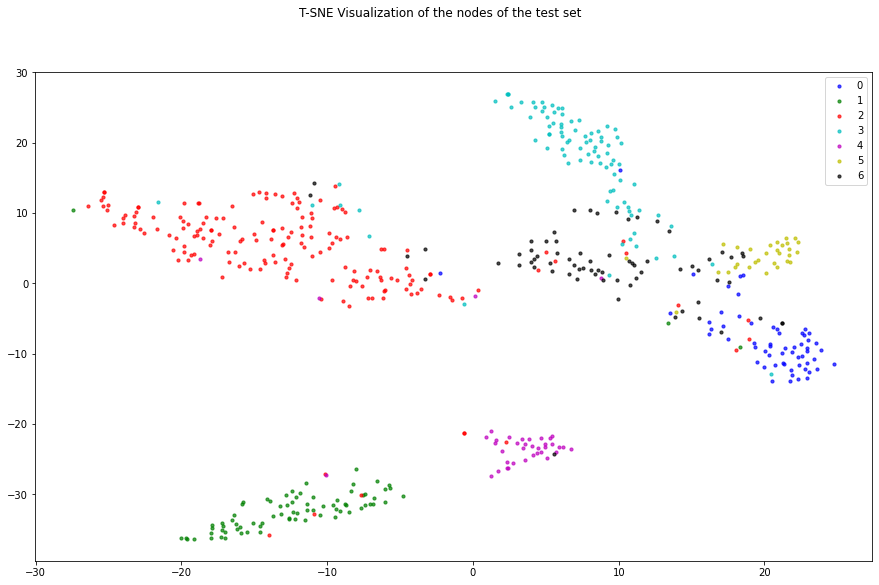

In [9]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

#from utils import load_cora, normalize_adjacency, sparse_to_torch_sparse
#from models import GNN

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
embeddings_test = test()



############## Task 13
# Transforms torch tensor to numpy matrix

##################
embeddings_test = embeddings_test.detach().cpu().numpy()
##################

# Projects the emerging representations to two dimensions using TSNE

##################
tsne = TSNE(n_components = 2)
embeddings_test_2d = tsne.fit_transform(embeddings_test)
##################


labels = class_labels[idx_test.cpu().numpy()]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()